In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.nn import Parameter

from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from lafomo.plot import Plotter, plot_phase
from experiments.lotka import build_lotka, plot_lotka
import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...


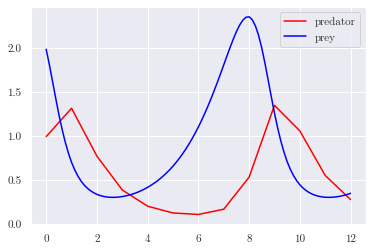

In [2]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

Num training points:  13
torch.Size([70, 1, 33])


/Users/jacob/Documents/proj/reggae/lafomo/models/variational_lfm.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


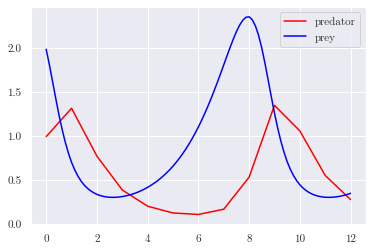

In [3]:
lfm, trainer, plotter = build_lotka(dataset, {
    'natural': False, 'kernel': 'rbf'
})

In [108]:
trainer.train(300, report_interval=10, step_size=1e-1)

Epoch 501/800 - Loss: -0.22 (-0.42 0.20) kernel: [[[2.893206]]]
Epoch 511/800 - Loss: -0.28 (-0.50 0.21) kernel: [[[2.890458]]]
Epoch 521/800 - Loss: -0.34 (-0.57 0.24) kernel: [[[2.8853538]]]
Epoch 531/800 - Loss: -0.34 (-0.60 0.26) kernel: [[[2.8767908]]]
Epoch 541/800 - Loss: -0.44 (-0.72 0.27) kernel: [[[2.8515573]]]
Epoch 551/800 - Loss: -0.49 (-0.79 0.30) kernel: [[[2.823923]]]
Epoch 561/800 - Loss: -0.55 (-0.88 0.33) kernel: [[[2.7900724]]]
Epoch 571/800 - Loss: -0.60 (-0.96 0.36) kernel: [[[2.7273154]]]
Epoch 581/800 - Loss: -0.70 (-1.10 0.40) kernel: [[[2.6866834]]]
Epoch 591/800 - Loss: -0.72 (-1.16 0.44) kernel: [[[2.630995]]]
Epoch 601/800 - Loss: -0.85 (-1.32 0.47) kernel: [[[2.5823548]]]
Epoch 611/800 - Loss: -0.80 (-1.29 0.50) kernel: [[[2.5292075]]]
Epoch 621/800 - Loss: -0.91 (-1.43 0.52) kernel: [[[2.482646]]]
Epoch 631/800 - Loss: -0.95 (-1.51 0.55) kernel: [[[2.4403043]]]
Epoch 641/800 - Loss: -1.01 (-1.59 0.58) kernel: [[[2.411539]]]
Epoch 651/800 - Loss: -1.10 (-1

tensor([[[2.4391]]], grad_fn=<SoftplusBackward>)
tensor([[[7.8229]]], grad_fn=<SoftplusBackward>)


MultitaskMultivariateNormal(loc: torch.Size([120]))

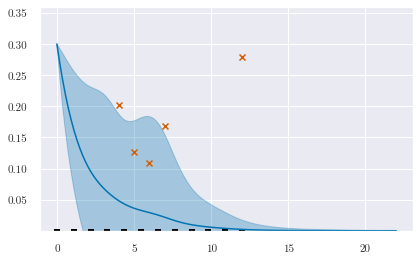

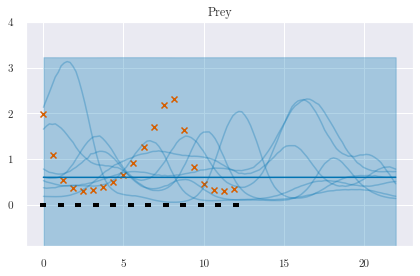

In [4]:
lfm.eval()
t_predict = torch.linspace(0, x_max+10, 120, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-2)
q_f = lfm.predict_f(t_predict)
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                titles=['Predator'])
plt.title('')
plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                t_scatter=dataset.times[::5],
                y_scatter=dataset.prey[None, None, ::5],
                ylim=(-0.9, 4),
                titles=['Prey'])

# labels = ['Initial', 'Grown rates', 'Decay rates']
# kinetics = list()
# for key in ['raw_initial', 'raw_growth', 'raw_decay']:
#     kinetics.append(softplus(torch.tensor(trainer.parameter_trace[key][-1])).squeeze().numpy())
#
# plotter.plot_double_bar(kinetics, labels)

In [111]:
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))
# with torch.no_grad():
#     lfm.raw_initial -= 0.1

tensor([[0.5101]], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.6089]], dtype=torch.float64, grad_fn=<LogBackward>)
{'constant': Parameter containing:
tensor([[0.3775]], requires_grad=True)}


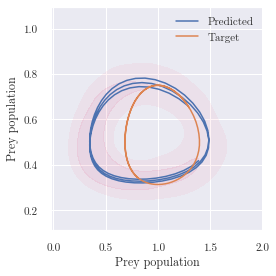

In [128]:
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred)
plt.xlabel('Prey population')
plt.ylabel('Prey population')
plt.tight_layout()
# plt.savefig('phaseplot.pdf')

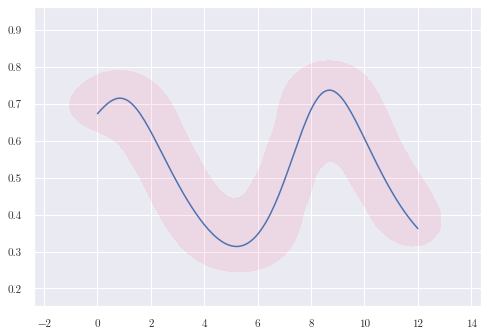

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())